In [1]:
import pandas as pd
import numpy as np


from sklearn import preprocessing,svm
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# Getting the Data


In [66]:
df=pd.read_csv("Crimes_2001_to_present.csv",encoding='latin1')

# Cleaning


In [53]:
#percent of invalid values
len(df[df.isnull().any(axis=1)])/len(df)*100
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603747 entries, 0 to 1603746
Data columns (total 23 columns):
Unnamed: 0              1603747 non-null int64
ID                      1603747 non-null int64
Case Number             1603747 non-null object
Date                    1603747 non-null object
Block                   1603747 non-null object
IUCR                    1603747 non-null object
Primary Type            1603747 non-null object
Description             1603747 non-null object
Location Description    1598650 non-null object
Arrest                  1603747 non-null bool
Domestic                1603747 non-null bool
Beat                    1603747 non-null int64
District                1603746 non-null float64
Ward                    1603723 non-null float64
Community Area          1603741 non-null float64
FBI Code                1603747 non-null object
X Coordinate            1584288 non-null float64
Y Coordinate            1584288 non-null float64
Year                    1

In [5]:
def trim_data(df):
    return df[(df['Year']>2014) & (df['Year']<2020)]
    
def clean_null_val(df):
    return df.dropna(axis=0)

def change_to_dateTime(df):
    datetimeCol=pd.to_datetime(df['Date'], infer_datetime_format=True)
    return df.assign(Date=datetimeCol)

def get_day_col(df):
    dayCol=pd.DatetimeIndex(df['Date']).day
    return df.assign(Day=dayCol)

def get_month_col(df):
    monthCol=pd.DatetimeIndex(df['Date']).month
    return df.assign(Month=monthCol)

def get_time_col(df):
    timeCol=pd.DatetimeIndex(df['Date']).time
    return df.assign(Time=timeCol)

def drop_unneccessary(df):
    return df.drop(columns=['Updated On','Location','X Coordinate','Y Coordinate','Case Number'])

In [6]:
chicagoCrime=(df.pipe(trim_data)
                .pipe(clean_null_val)
                .pipe(change_to_dateTime)
                .pipe(get_day_col)
                .pipe(get_month_col)
                .pipe(get_time_col)
                .pipe(drop_unneccessary))


# Extracting Location Data for Specific Crimes

In [38]:
latLon=chicagoCrime[chicagoCrime['Primary Type']=='CRIMINAL DAMAGE']
latLon=latLon[['Latitude','Longitude']]
latLon.to_excel('CriminalDamageLocations.xlsx')

# Exploratory Questions

1.Number Of Crimes vs. Number Of arrest in a year


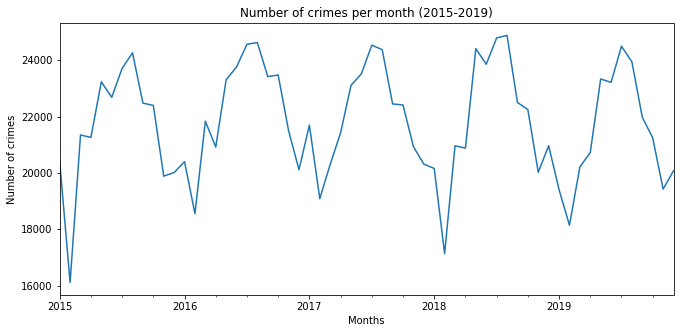

In [41]:
plt.figure(figsize=(11,5))
chicagoCrime.resample('M',on='Date').size().plot(legend = False)
plt.title ('Number of crimes per month (2015-2019)')
plt.xlabel ('Months')
plt.ylabel('Number of crimes')
plt.show()

In [42]:
numArrestPerYear=chicagoCrime[chicagoCrime['Arrest']==True]
numArrestPerYear=numArrestPerYear.groupby('Year')['Arrest'].count()
numArrestPerYear

Year
2015    67461
2016    52791
2017    52158
2018    52788
2019    54604
Name: Arrest, dtype: int64

In [43]:
numCrimesPerYear=chicagoCrime.groupby('Year')['Primary Type'].count()#.plot.barh(figsize=(10, 10))
numCrimesPerYear

Year
2015    257748
2016    266453
2017    264116
2018    262790
2019    256175
Name: Primary Type, dtype: int64

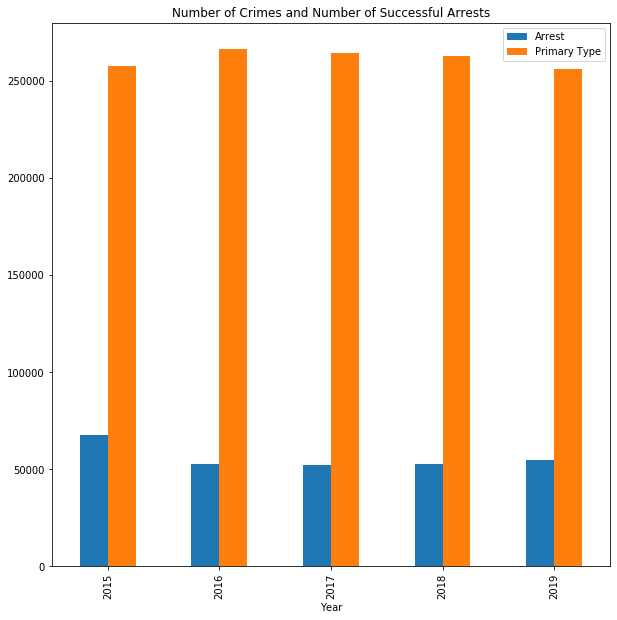

In [134]:
crimesVsArrest=pd.DataFrame.merge(numArrestPerYear,numCrimesPerYear,left_index=True,right_index=True)
crimesVsArrest.plot.bar(title="Number of Crimes and Number of Successful Arrests",figsize=(10, 10))

In [59]:
crimesVsArrest['Arrest Rate']=crimesVsArrest['Arrest']/crimesVsArrest['Primary Type'] *100
crimesVsArrest['Arrest Rate'].mean()

21.427303737431583

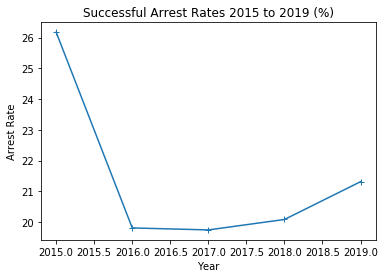

In [58]:
crimesVsArrest=crimesVsArrest.reset_index()
plt.figure()     # this creates the figure, but usually this is not necessary
plt.plot(crimesVsArrest['Year'], crimesVsArrest['Arrest Rate'], '+-')     # line plotting
plt.xlabel('Year')         # x-label text
plt.ylabel('Arrest Rate')         # y-label text
plt.title('Successful Arrest Rates 2015 to 2019 (%)')      # title text
plt.show() 

2. Types of commited crimes

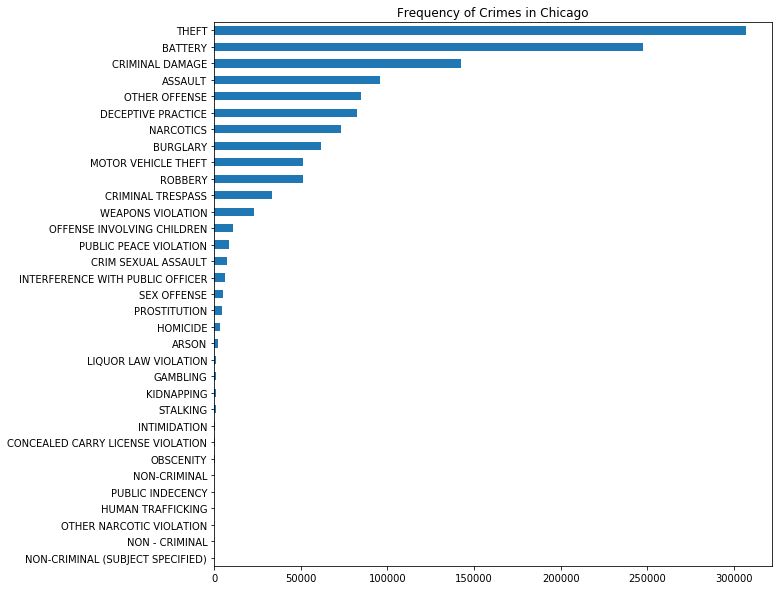

In [131]:
typeOfCrimes=chicagoCrime['Primary Type'].value_counts().sort_values(ascending=True)
typeOfCrimes.plot.barh(title="Frequency of Crimes in Chicago",figsize=(10, 10))

Time Line Of Each Crime

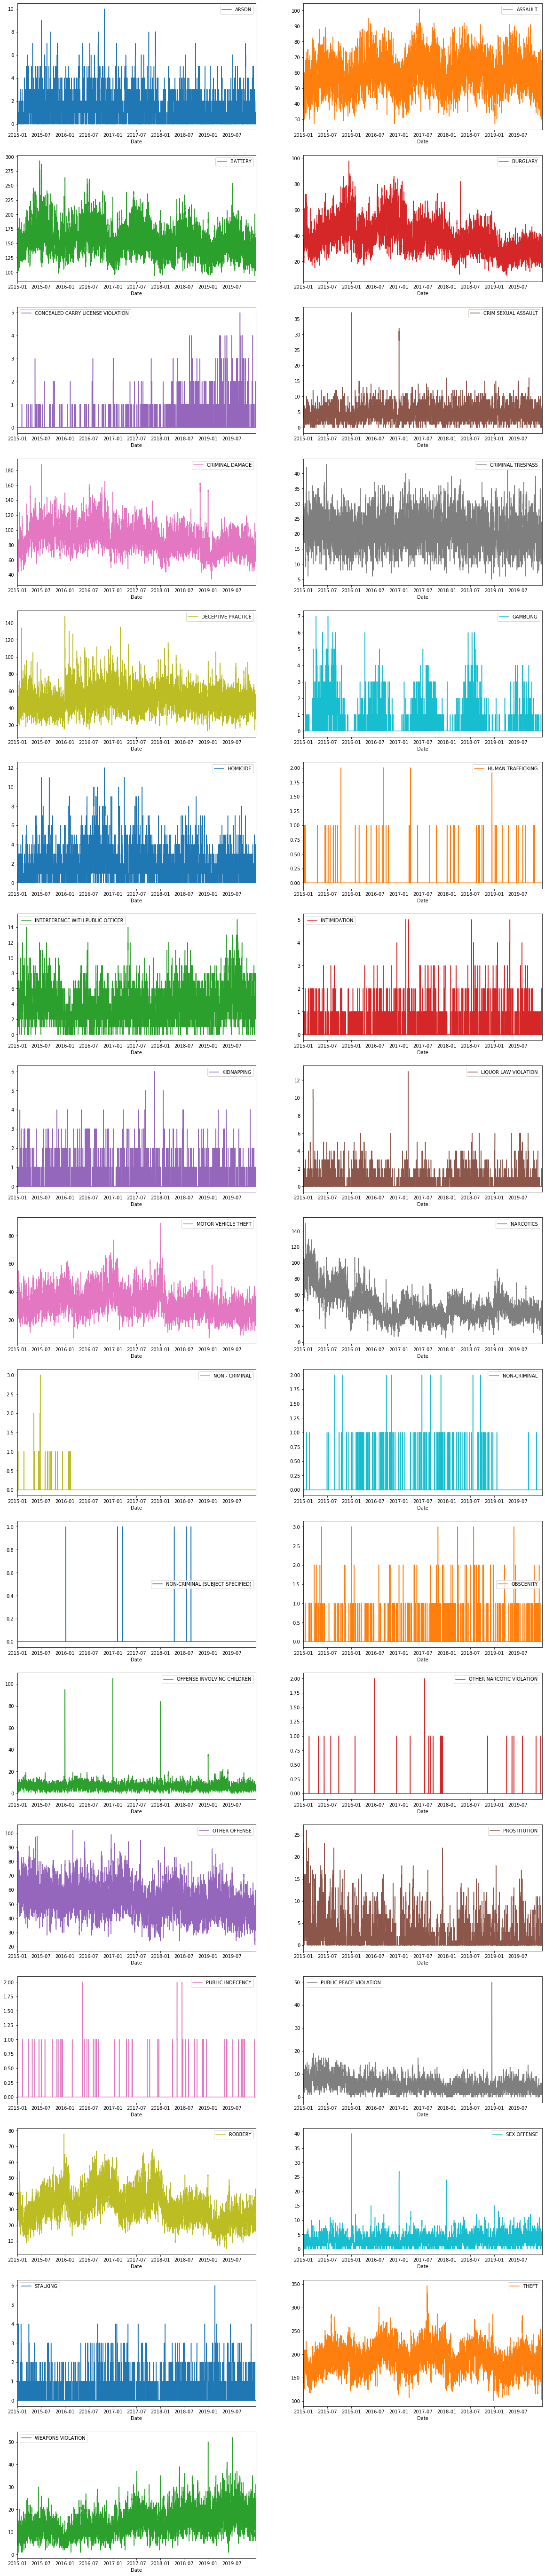

In [40]:
#focus is on each crime
#helps to focus in crime that are up on the rise

crimes_count = chicagoCrime.pivot_table('ID', aggfunc=np.size, columns='Primary Type',
                             index=chicagoCrime['Date'], fill_value=0)
crimes_count.index = pd.DatetimeIndex(crimes_count.index)
plot = crimes_count.rolling(365).sum().plot(figsize=(20 ,100), subplots = True,
                                           layout=(-1,2), sharex= False, sharey= False)


3. Locations Of Crime

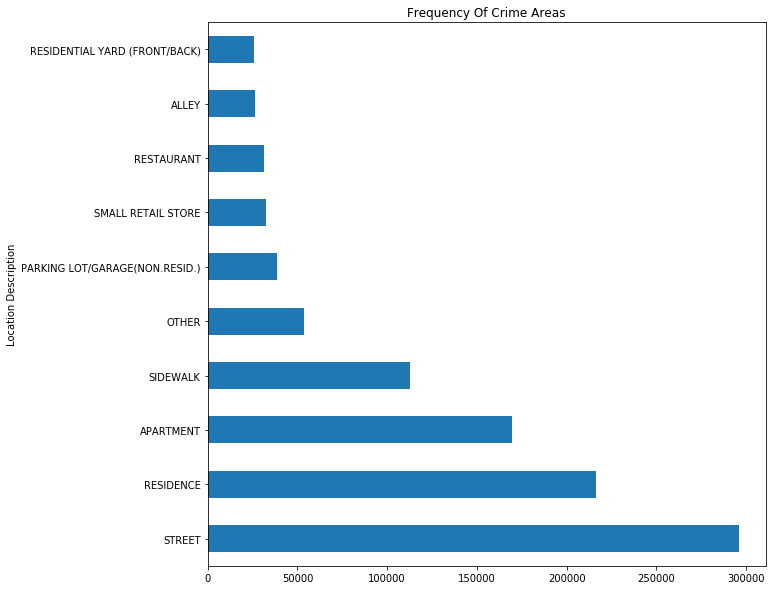

In [142]:
chicagoCrime.groupby('Location Description')['Primary Type'].count().sort_values(ascending=False).head(10).plot.barh(title='Frequency Of Crime Areas',figsize=(10, 10))

4. Time Analysis Of Crime

In [51]:
timeAnalysis=pd.DataFrame(chicagoCrime.groupby('Time')['ID'].count())
timeAnalysis

,ID
Time,
00:00:00,14776
00:01:00,12924
00:02:00,454
00:03:00,358
00:04:00,315
...,...
23:55:00,1068
23:56:00,249
23:57:00,258


In [52]:
xi=['00:00:00','01:00:00','02:00:00','03:00:00','04:00:00','05:00:00','06:00:00',
    '07:00:00','08:00:00','09:00:00','10:00:00','11:00:00','12:00:00',
    '13:00:00','14:00:00','15:00:00','16:00:00','17:00:00','18:00:00',
    '19:00:00','20:00:00','21:00:00','22:00:00','23:00:00']

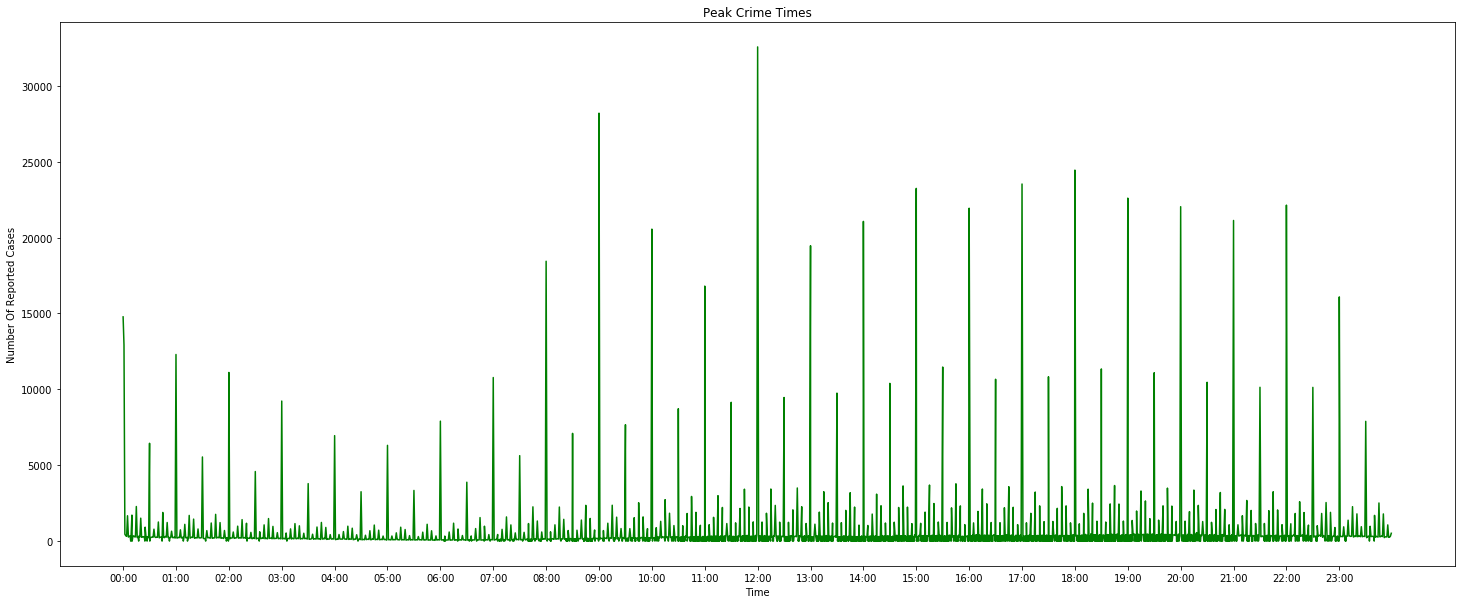

In [60]:
timeAnalysis=timeAnalysis.reset_index()
plt.figure(figsize=(25,10))   # this creates the figure, but usually this is not necessary
plt.plot(timeAnalysis['Time'], timeAnalysis['ID'], 'g')     # line plotting
plt.xticks(xi)
plt.xlabel('Time')         # x-label text
plt.ylabel('Number Of Reported Cases')         # y-label text
plt.title('Peak Crime Times')      # title text
plt.show() 

In [ ]:
df.nunique()

# Model Training (Logistic Regression)



4. Predicting domestic Crime


In [73]:
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()
chicagoCrimeT=chicagoCrime.apply(encoder.fit_transform)


,Unnamed: 0,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude,Day,Month,Time
13075,0,1052766,462611,723,287,27,217,1,0,0,...,14,40,75,25,4,334628,87,2,0,2096
14756,1,1097422,485544,1052,40,2,276,136,0,0,...,0,41,31,10,4,203288,262229,15,2,1850
15084,2,1095041,484209,4349,85,31,0,121,0,0,...,1,3,35,7,4,150473,304399,11,2,2432
15116,3,1097345,484831,28381,40,2,276,118,0,0,...,20,48,0,10,4,339743,178319,13,2,1990
15117,4,1095379,484781,4349,332,24,216,136,0,1,...,1,3,35,25,4,150459,304272,13,2,1532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603739,1307277,49683,21654,17145,40,2,276,118,0,0,...,21,34,20,10,0,279889,89300,17,2,257
1603740,1307278,49684,21807,19299,74,1,276,122,1,0,...,14,37,14,9,0,302279,24771,17,2,1707
1603742,1307279,1146692,510321,17163,279,24,151,17,0,1,...,9,23,28,25,4,177009,91175,25,4,1721
1603743,1307280,2700,510171,7076,0,10,132,37,1,0,...,11,24,27,0,4,178213,210119,25,4,433


In [78]:
XX=chicagoCrimeT.drop(['ID','Date','Domestic','Unnamed: 0'],axis=1)
yy=chicagoCrimeT['Domestic']
yy

13075      0
14756      0
15084      0
15116      0
15117      1
          ..
1603739    0
1603740    0
1603742    1
1603743    0
1603744    0
Name: Domestic, Length: 1307282, dtype: int64

In [79]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
cv_model = cross_validate(lr_model, XX, yy, cv=3, return_train_score=True,return_estimator=True, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  21.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.2s remaining:    0.0s


[CV] ................................................. , total=  11.7s
[CV]  ................................................................
[CV] ................................................. , total=  10.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   44.0s finished


Test Scores


In [80]:
#cv_model.keys()
print(cv_model['train_score'].mean())
print(cv_model['test_score'].mean())
#lr_model

0.8368221242658261
0.8368049125735929


In [138]:
cv_model['train_score']

array([0.8370766 , 0.8367098 , 0.83667997])

# Testing Model


In [67]:
testDataset=(df.pipe(clean_null_val)
                .pipe(change_to_dateTime)
                .pipe(get_day_col)
                .pipe(get_month_col)
                .pipe(get_time_col)
                .pipe(drop_unneccessary))

In [68]:
testDataset=testDataset[testDataset['Year']>2019]

In [87]:
testDatasetTransformed=testDataset.apply(encoder.fit_transform)
x_td=testDatasetTransformed.drop(['ID','Date','Domestic'],axis=1)
y_td_actual=testDatasetTransformed['Domestic']
y_td_actual

187868    0
188036    0
188394    1
189747    0
189748    0
         ..
259367    0
259368    0
259369    0
259370    0
259371    0
Name: Domestic, Length: 22433, dtype: int64

In [96]:
testDataset['predicted_val']=cv_model['estimator'][0].predict(x_td)
testDataset['actual_val']=y_td_actual
testDataset['results']=testDataset['predicted_val']-testDataset['actual_val']
testDataset

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,FBI Code,Year,Latitude,Longitude,Day,Month,Time,predicted_val,actual_val,results
187868,11946909,2020-01-09 14:25:00,059XX S ASHLAND AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,AUTO / BOAT / RV DEALERSHIP,False,False,713,...,07,2020,41.785960,-87.664375,9,1,14:25:00,0,0,0
188036,11946915,2020-01-09 16:58:00,076XX S STEWART AVE,0610,BURGLARY,FORCIBLE ENTRY,APARTMENT,False,False,621,...,05,2020,41.755613,-87.634421,9,1,16:58:00,0,0,0
188394,11946971,2020-01-09 15:53:00,048XX W RACE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,True,1532,...,08B,2020,41.890471,-87.746016,9,1,15:53:00,0,1,-1
189747,11947070,2020-01-09 18:46:00,043XX S DR MARTIN LUTHER KING JR DR,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,STREET,True,False,215,...,15,2020,41.815849,-87.616771,9,1,18:46:00,0,0,0
189748,11947098,2020-01-09 18:30:00,097XX S HALSTED ST,1330,CRIMINAL TRESPASS,TO LAND,MEDICAL/DENTAL OFFICE,False,False,2223,...,26,2020,41.716960,-87.643088,9,1,18:30:00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259367,11975165,2020-02-06 09:00:00,060XX S KOLMAR AVE,0820,THEFT,$500 AND UNDER,STREET,False,False,813,...,06,2020,41.783145,-87.736331,6,2,09:00:00,0,0,0
259368,11974163,2020-02-06 23:58:00,031XX W 83RD ST,1812,NARCOTICS,POSS: CANNABIS MORE THAN 30GMS,STREET,True,False,835,...,18,2020,41.742510,-87.701424,6,2,23:58:00,0,0,0
259369,11977603,2020-01-30 18:00:00,003XX E 47th st,0860,THEFT,RETAIL THEFT,SMALL RETAIL STORE,False,False,215,...,06,2020,41.809365,-87.617753,30,1,18:00:00,0,0,0
259370,11973882,2020-02-06 16:40:00,048XX W VAN BUREN ST,1821,NARCOTICS,MANU/DEL:CANNABIS 10GM OR LESS,SIDEWALK,True,False,1533,...,18,2020,41.874964,-87.746081,6,2,16:40:00,0,0,0


In [97]:
def encode_units(x):
    if x < 0:
        return 'FALSE NEGATIVE'
    if x > 0:
        return 'FALSE POSITIVE'
    if x == 0:
        return 'TRUE'

In [109]:
results=testDataset['results']
results=pd.DataFrame(results).applymap(encode_units)
testDataset['Summary']=results
testDataset

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,Year,Latitude,Longitude,Day,Month,Time,predicted_val,actual_val,results,Summary
187868,11946909,2020-01-09 14:25:00,059XX S ASHLAND AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,AUTO / BOAT / RV DEALERSHIP,False,False,713,...,2020,41.785960,-87.664375,9,1,14:25:00,0,0,0,TRUE
188036,11946915,2020-01-09 16:58:00,076XX S STEWART AVE,0610,BURGLARY,FORCIBLE ENTRY,APARTMENT,False,False,621,...,2020,41.755613,-87.634421,9,1,16:58:00,0,0,0,TRUE
188394,11946971,2020-01-09 15:53:00,048XX W RACE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,True,1532,...,2020,41.890471,-87.746016,9,1,15:53:00,0,1,-1,FALSE NEGATIVE
189747,11947070,2020-01-09 18:46:00,043XX S DR MARTIN LUTHER KING JR DR,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,STREET,True,False,215,...,2020,41.815849,-87.616771,9,1,18:46:00,0,0,0,TRUE
189748,11947098,2020-01-09 18:30:00,097XX S HALSTED ST,1330,CRIMINAL TRESPASS,TO LAND,MEDICAL/DENTAL OFFICE,False,False,2223,...,2020,41.716960,-87.643088,9,1,18:30:00,0,0,0,TRUE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259367,11975165,2020-02-06 09:00:00,060XX S KOLMAR AVE,0820,THEFT,$500 AND UNDER,STREET,False,False,813,...,2020,41.783145,-87.736331,6,2,09:00:00,0,0,0,TRUE
259368,11974163,2020-02-06 23:58:00,031XX W 83RD ST,1812,NARCOTICS,POSS: CANNABIS MORE THAN 30GMS,STREET,True,False,835,...,2020,41.742510,-87.701424,6,2,23:58:00,0,0,0,TRUE
259369,11977603,2020-01-30 18:00:00,003XX E 47th st,0860,THEFT,RETAIL THEFT,SMALL RETAIL STORE,False,False,215,...,2020,41.809365,-87.617753,30,1,18:00:00,0,0,0,TRUE
259370,11973882,2020-02-06 16:40:00,048XX W VAN BUREN ST,1821,NARCOTICS,MANU/DEL:CANNABIS 10GM OR LESS,SIDEWALK,True,False,1533,...,2020,41.874964,-87.746081,6,2,16:40:00,0,0,0,TRUE


In [136]:
testDataset.groupby('Summary')['ID'].count()

Summary
FALSE NEGATIVE     3513
FALSE POSITIVE      101
TRUE              18819
Name: ID, dtype: int64

In [ ]:
testDataset.groupby('Summary')['ID'].count().plot.bar(x='Results',y='Number of Cases',title="Results of Domestic Case Prediction Model",figsize=(7, 7))

# Saving The Model


In [140]:
import pickle

best_homicide_model = cv_model['estimator'][0]

with open('homicide_model.pkl', 'wb') as file:
    pickle.dump(best_homicide_model, file)

# Loading The Model

In [141]:
with open('homicide_model.pkl', 'rb') as file:
    loaded_homicide_model = pickle.load(file, encoding='bytes')